This file contains analysis of the SOSI indicator buy signals on a 5 min chart data and the best possible profit loss combinations for the indicator and the total profit and drawdown scenario.
all data inclusive of trades taken inside the paticular referemce expiry week and taken with a margin of error for higher accuracy.
This contains latest updates of brokerages and drawdown descriptions.


Processing NSE_NIFTY240627C23500, 5.csv in NIFTY...
No buy signals found for NSE_NIFTY240627C23500, 5.csv. Skipping...
Processing NSE_NIFTY240627C23600, 5.csv in NIFTY...
No buy signals found for NSE_NIFTY240627C23600, 5.csv. Skipping...
Processing NSE_NIFTY240627C23700, 5.csv in NIFTY...
No buy signals found for NSE_NIFTY240627C23700, 5.csv. Skipping...
Processing NSE_NIFTY240627C23750, 5.csv in NIFTY...
No buy signals found for NSE_NIFTY240627C23750, 5.csv. Skipping...
Processing NSE_NIFTY240627C23800, 5.csv in NIFTY...
No buy signals found for NSE_NIFTY240627C23800, 5.csv. Skipping...
Processing NSE_NIFTY240627P23600, 5.csv in NIFTY...
No buy signals found for NSE_NIFTY240627P23600, 5.csv. Skipping...
Processing NSE_NIFTY240627P23700, 5.csv in NIFTY...
No buy signals found for NSE_NIFTY240627P23700, 5.csv. Skipping...
Processing NSE_NIFTY240627P23800, 5.csv in NIFTY...
No buy signals found for NSE_NIFTY240627P23800, 5.csv. Skipping...
Processing NSE_NIFTY240704C23800, 5.csv in NIFTY

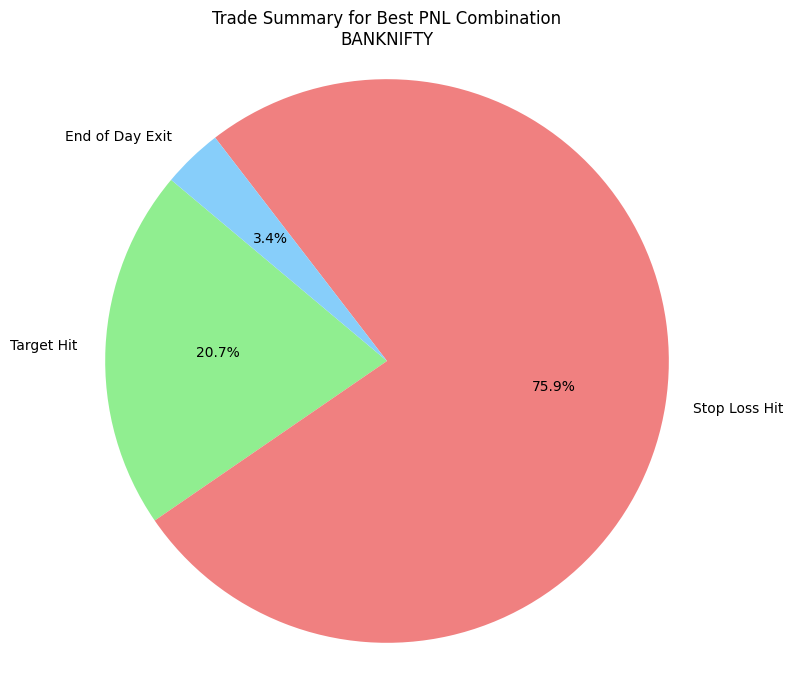

29


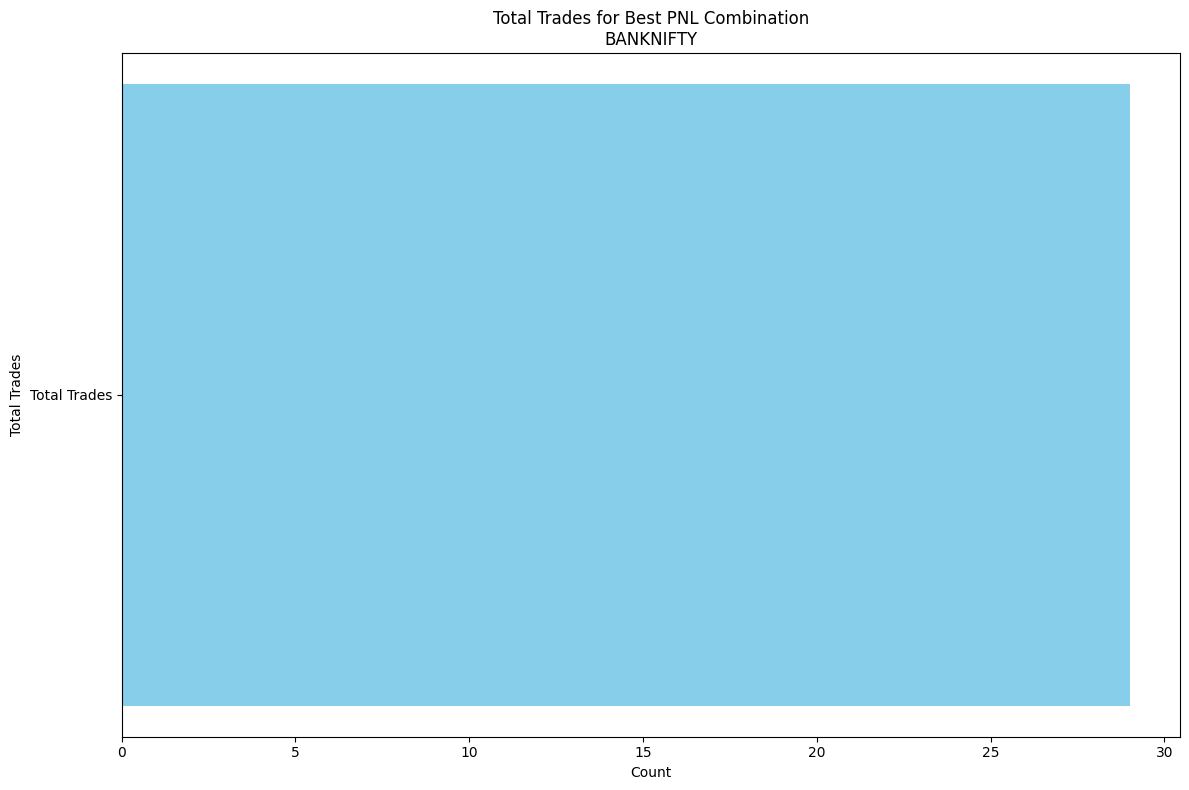

-399.95091591084895


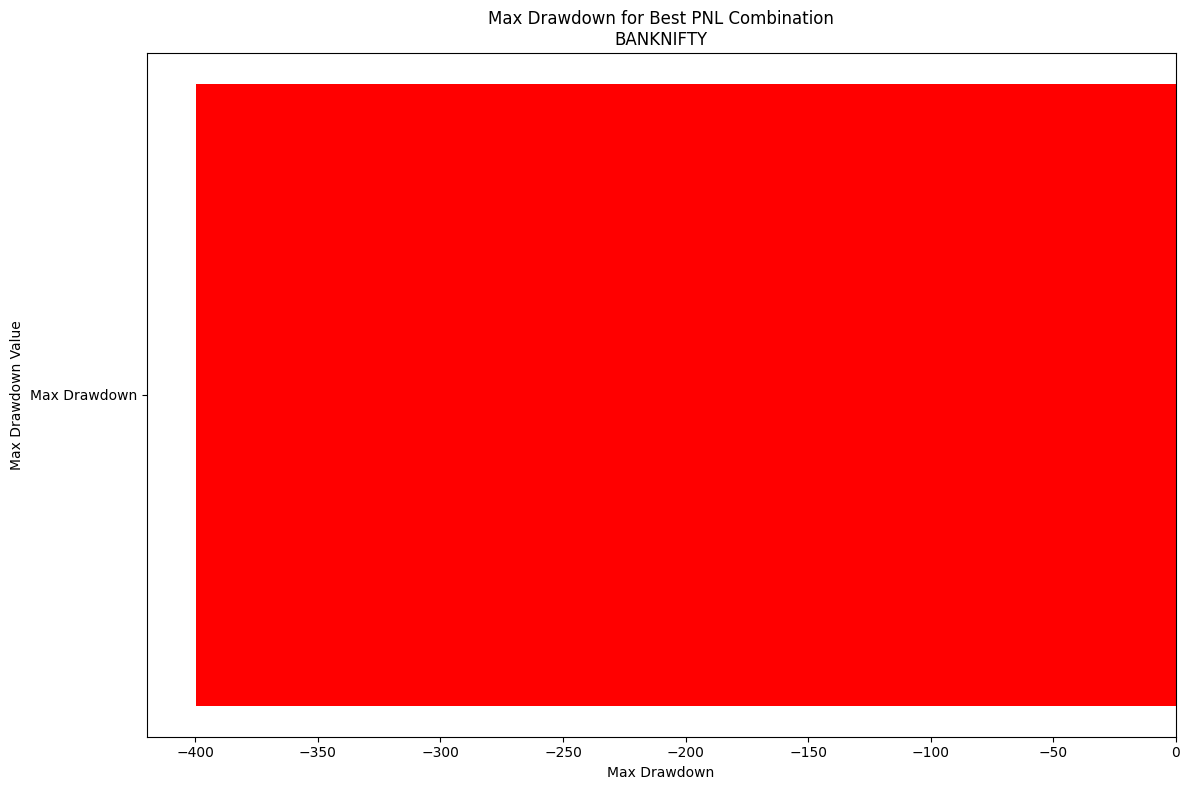

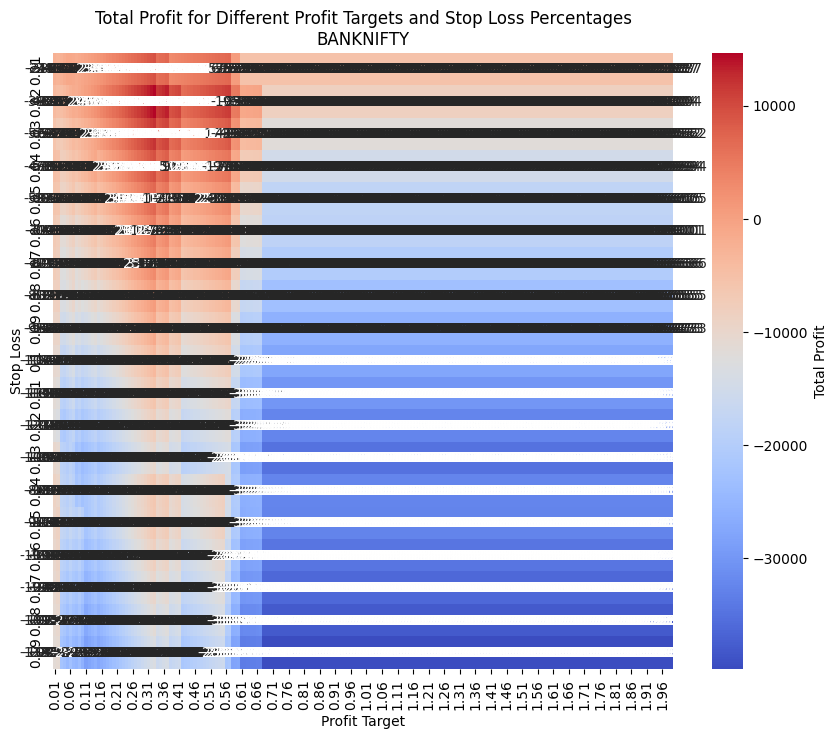

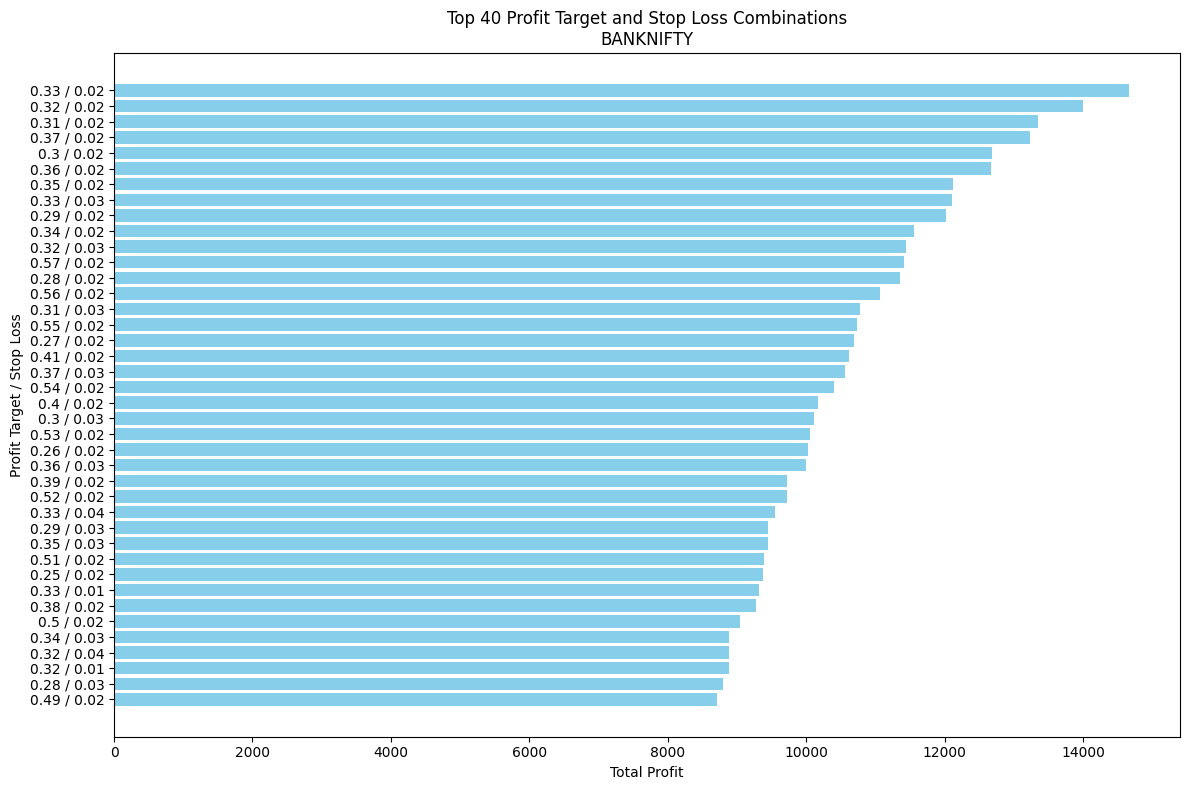

Processing NSE_FINNIFTY240702C23100, 5.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240702C23100, 5.csv. Skipping...
Processing NSE_FINNIFTY240702C23400, 5.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240702C23400, 5.csv. Skipping...
Processing NSE_FINNIFTY240702C23450, 5.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240702C23450, 5.csv. Skipping...
Processing NSE_FINNIFTY240702C23500, 5.csv in FINNIFTY...
Processing NSE_FINNIFTY240702C23600, 5.csv in FINNIFTY...
Processing NSE_FINNIFTY240702C23650, 5.csv in FINNIFTY...
Processing NSE_FINNIFTY240702C23700, 5.csv in FINNIFTY...
Processing NSE_FINNIFTY240702P23400, 5.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240702P23400, 5.csv. Skipping...
Processing NSE_FINNIFTY240702P23500, 5.csv in FINNIFTY...
No buy signals found for NSE_FINNIFTY240702P23500, 5.csv. Skipping...
Processing NSE_FINNIFTY240702P23600, 5.csv in FINNIFTY...
Processing NSE_FINNIFTY240702P23700, 5.csv in FINNIFTY...
{'Total Trad

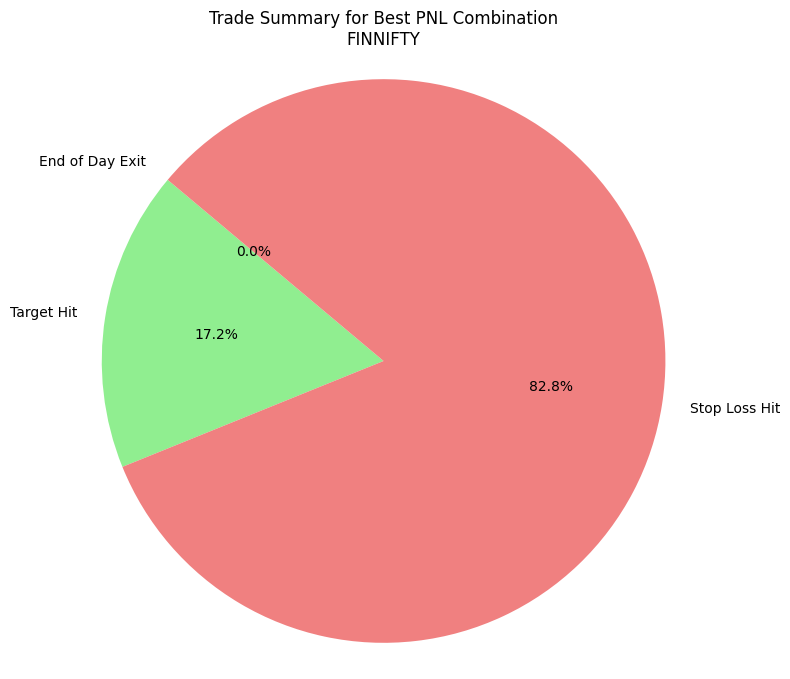

29


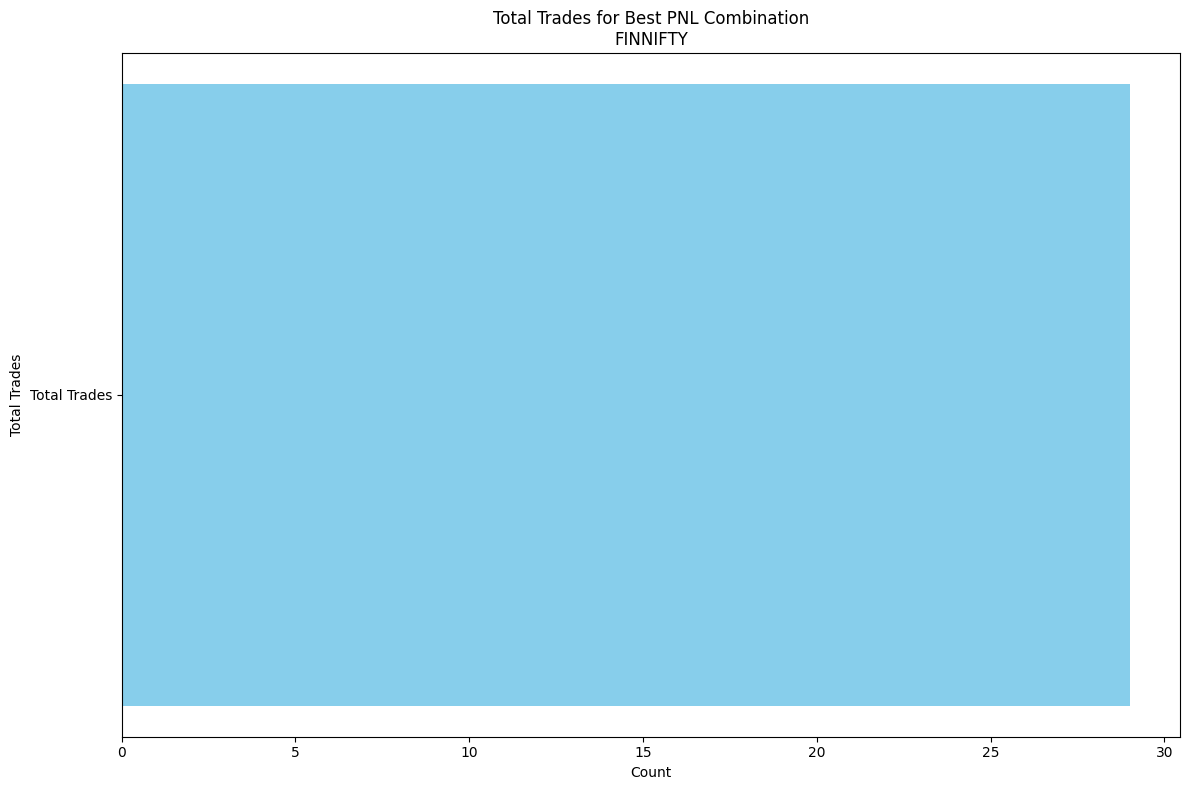

-176.34769615090033


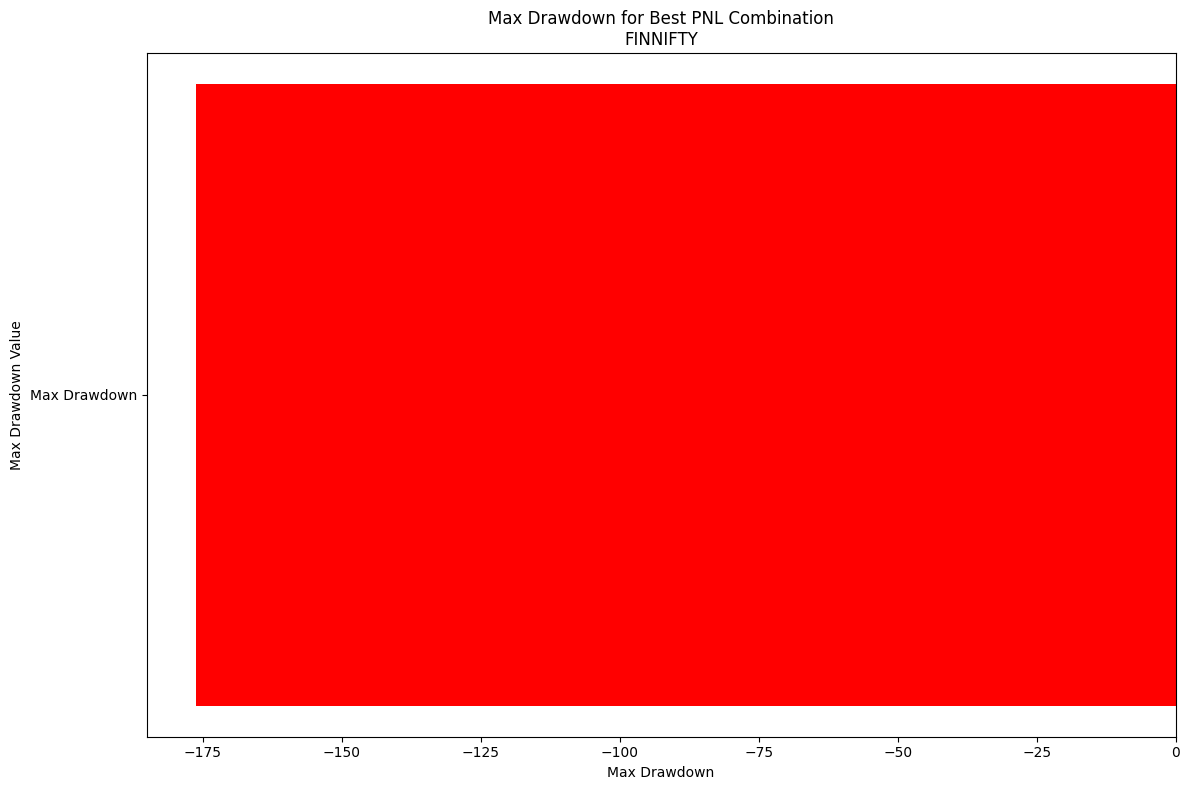

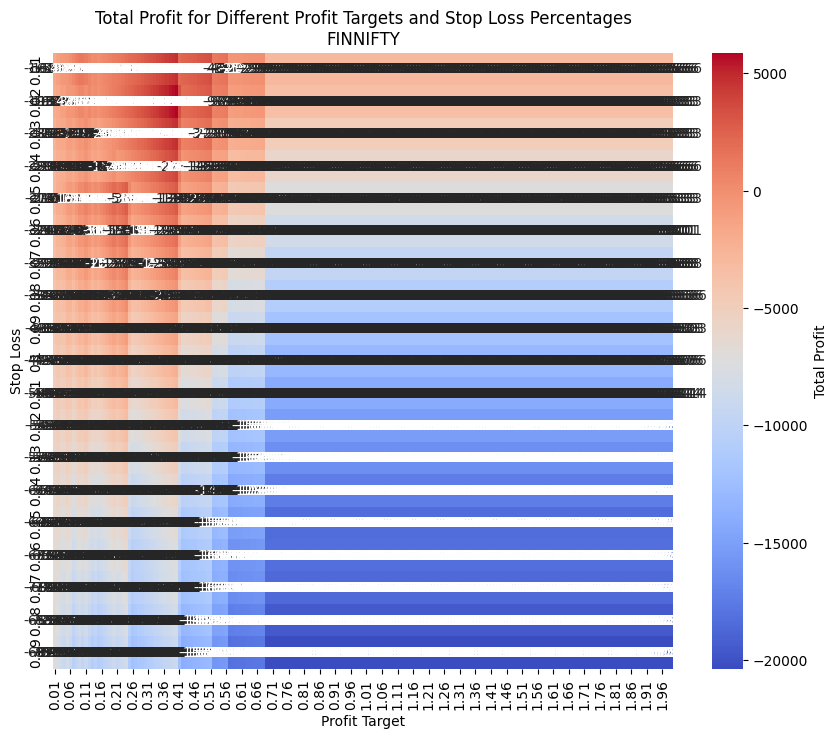

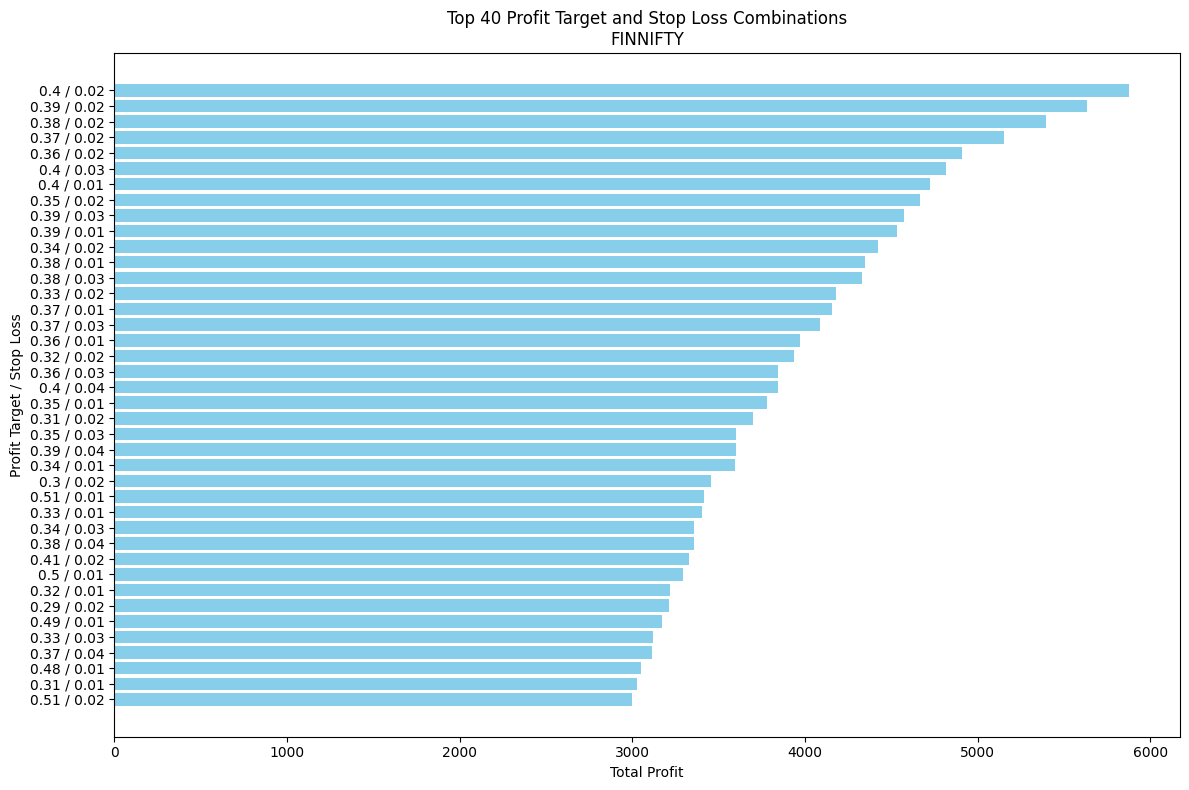

Analysis complete.


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to filter buy signals from the 5-minute chart data
def filter_signals(data):
    if 'Strong Buy Signal' not in data.columns:
        print("Warning: 'sosi Strong Buy Signal' column not found in the data.")
        return pd.DataFrame()  # Return an empty DataFrame if the column is not found
    buy_signals = data[(data['Strong Buy Signal'] == True)]
    return buy_signals

# Function to calculate charges
def calculate_charges(entry_price, exit_price, quantity):
    brokerage = 40  # total brokerage for one complete buy and sell
    stt_ctt = 0.00125 * exit_price * quantity
    transaction_charges = 0.000495 * (entry_price + exit_price) * quantity
    gst = 0.18 * (brokerage + transaction_charges)
    sebi_charges = 10 / 10**7 * (entry_price + exit_price) * quantity
    stamp_charges = 0.00003 * entry_price * quantity
    total_charges = brokerage + stt_ctt + transaction_charges + gst + sebi_charges + stamp_charges
    return total_charges

# Function to simulate day trades with error margin
def simulate_day_trades(buy_signals, minute_data, symbol, profit_target=0.02, stop_loss=0.01, min_stop_loss=0.005, error_margin=0.01):
    results = []

    for index, buy_signal in buy_signals.iterrows():
        entry_price = buy_signal['close'] * (1 + error_margin)  # Adjust entry price with error margin
        entry_time = buy_signal['time'] + 300  # Add 15 minutes to the buy signal time to get the entry time
        profit_price = entry_price * (1 + profit_target)
        stop_price = entry_price * (1 - max(stop_loss, min_stop_loss))  # Ensure stop loss is at least min_stop_loss
        
        trade_result = {
            'signal_time': buy_signal['time'],
            'entry_time': entry_time,
            'entry_price': entry_price,
            'Target Profit': profit_target,
            'Stop Loss': stop_loss,
            'Profit Price': profit_price,
            'Stop Price': stop_price,
            'exit_time': None,
            'exit_price': None,
            'charges': None,
            'profit_before_charges': None,
            'profit': None,
            'exit_reason': None
        }
        
        # Filter subsequent data for the same day only
        trade_date = pd.to_datetime(entry_time, unit='s').date()
        subsequent_data = minute_data[(minute_data['time'] > entry_time) & 
                                      (pd.to_datetime(minute_data['time'], unit='s').dt.date == trade_date)]
        
        for _, row in subsequent_data.iterrows():
            if row['high'] >= profit_price:
                trade_result['exit_time'] = row['time']
                trade_result['exit_price'] = profit_price
                trade_result['exit_reason'] = 'Target Hit'
                break
            if row['low'] <= stop_price:
                trade_result['exit_time'] = row['time']
                trade_result['exit_price'] = stop_price
                trade_result['exit_reason'] = 'Stop Loss Hit'
                break
        else:
            # If no target or stop loss hit, exit at the last price of the day
            trade_result['exit_reason'] = 'End of Day Exit'
            if not subsequent_data.empty:
                last_row = subsequent_data.iloc[-1]
                trade_result['exit_time'] = last_row['time']
                trade_result['exit_price'] = last_row['close']
        
        if trade_result['exit_price'] is not None:
            quantity = 25 if 'NIFTY' in symbol else 15 if 'BANKNIFTY' in symbol else 40 if 'FINNIFTY' in symbol else 10
            gross_profit = (trade_result['exit_price'] - trade_result['entry_price']) * quantity
            charges = calculate_charges(trade_result['entry_price'], trade_result['exit_price'], quantity)
            net_profit = gross_profit - charges
            trade_result['charges'] = charges
            trade_result['profit_before_charges'] = gross_profit
            trade_result['profit'] = net_profit

        results.append(trade_result)
    
    results_df = pd.DataFrame(results)

    return results_df.dropna(subset=['entry_price'])

# Function to analyze profit and stop loss percentages
def analyze_profit_and_stop_loss(buy_signals, minute_data, profit_percentages, stop_loss_percentages, min_stop_loss=0.005, error_margin=0.01):
    analysis_results = []
    finalresults = []
    for profit_target in profit_percentages:
        for stop_loss in stop_loss_percentages:
            trade_results = simulate_day_trades(buy_signals, minute_data, folder_name, profit_target, stop_loss, min_stop_loss, error_margin)
            total_profit = trade_results['profit'].sum()
            charges = trade_results['charges'].sum()
            profit_before_charges = trade_results['profit_before_charges'].sum()
            analysis_results.append((profit_target, stop_loss, charges, profit_before_charges, total_profit))
            finalresults.append(trade_results)
    # Combine all trade results into a single DataFrame
    combined_trade_results = pd.concat(finalresults, ignore_index=True)
 
    return pd.DataFrame(analysis_results, columns=['Profit Target', 'Stop Loss', 'Charges', 'Profit Before Charges', 'Total Profit']), combined_trade_results

# Function to summarize trade results
def summarize_trade_results(trade_results):
    total_trades = len(trade_results)
    target_hit = len(trade_results[trade_results['exit_reason'] == 'Target Hit'])
    stop_loss_hit = len(trade_results[trade_results['exit_reason'] == 'Stop Loss Hit'])
    end_of_day_exit = len(trade_results[trade_results['exit_reason'] == 'End of Day Exit'])
    max_drawdown = trade_results['profit'].min()
    summary = {
        'Total Trades': total_trades,
        'Target Hit': target_hit,
        'Stop Loss Hit': stop_loss_hit,
        'End of Day Exit': end_of_day_exit,
        'Max Drawdown': max_drawdown
    }
    return summary

# Define profit percentages and stop loss percentages to analyze
profit_percentages = [i / 100 for i in range(1, 200)]
stop_loss_percentages = [i / 100 for i in range(1, 20)]

# Directories containing the data
directories = ['June 2024/NIFTY', 'June 2024/BANKNIFTY', 'June 2024/FINNIFTY']  # Change the directories as needed

# Function to check if the date is within the week of expiration
def is_within_expiry_week(expiry_date, timestamp, folder_name, days_before_expiry=5):
    # Assuming the date is the 7th to 12th characters in the string
    if folder_name == 'NIFTY':
        date_part = expiry_date[9:15]
    if folder_name == 'BANKNIFTY':
        date_part = expiry_date[13:19]
    if folder_name == 'FINNIFTY':
        date_part = expiry_date[12:18]
    if folder_name == 'SENSEX':
        date_part = expiry_date[7:13]
    
    expiry_datetime = pd.to_datetime(date_part, format='%y%m%d')
    signal_datetime = pd.to_datetime(timestamp, unit='s')
    return (expiry_datetime - signal_datetime).days <= days_before_expiry

# Process each directory
for directory in directories:
    pnl_results = []
    trade_results_combined = []
    all_combined_results = []
    folder_name = os.path.basename(directory)
    for subdir, _, files in os.walk(directory):
        if subdir == directory:
            continue  # Skip the top-level directory itself
        for filename in files:
            if ', 5.csv' in filename:
                minute_5_path = os.path.join(subdir, filename)
                minute_1_path = minute_5_path.replace(', 5.csv', ', 1.csv')
                
                if os.path.exists(minute_1_path):
                    print(f"Processing {filename} in {folder_name}...")
                    
                    # Extract expiry date from filename
                    expiry_date = filename.split(' ')[0].split(',')[0]
                    
                    # Load the CSV files
                    minute_data_5 = pd.read_csv(minute_5_path)
                    minute_data_1 = pd.read_csv(minute_1_path)
                    
                    # Filter buy signals
                    buy_signals = filter_signals(minute_data_5)

                    # Skip if no buy signals
                    if buy_signals.empty:
                        print(f"No buy signals found for {filename}. Skipping...")
                        continue
                    # Filter signals to only include those within the expiry week
                    buy_signals = buy_signals[buy_signals['time'].apply(lambda x: is_within_expiry_week(expiry_date, x, folder_name))]
                    
                    # Skip if no buy signals within expiry week
                    if buy_signals.empty:
                        print(f"No buy signals found within expiry week for {filename}. Skipping...")
                        continue
                    
                    # Perform the analysis
                    analysis_results, trade_results = analyze_profit_and_stop_loss(buy_signals, minute_data_1, profit_percentages, stop_loss_percentages)
                    
                    # Merge buy signals with trade results
                    combined_results = pd.merge(buy_signals, trade_results, left_on='time', right_on='signal_time', how='inner')
                    
                                        # Merge the 15-minute chart data with combined results
                    combined_results = pd.merge(combined_results, minute_data_5, left_on='time', right_on='time', suffixes=('_buy', '_original'))
                   
                    all_combined_results.append(combined_results)
                    
                    # Append to combined results
                    pnl_results.append(analysis_results)
                    trade_results_combined.append(trade_results)
    
    # Combine all results for the folder
    if not pnl_results:
        print(f"No data found for {folder_name}. Skipping...")
        continue    
    combined_pnl_results = pd.concat(pnl_results, ignore_index=True)
    # Aggregate total profits for the same combinations
    combined_pnl_results = combined_pnl_results.groupby(['Profit Target', 'Stop Loss'], as_index=False)['Total Profit'].sum()
    combined_trade_results = pd.concat(trade_results_combined, ignore_index=True)
    combined_all_results = pd.concat(all_combined_results, ignore_index=True)
    
    # Save the results to CSV files
    combined_pnl_results.to_csv(f'Outputs/DayTrade/SOSI/5min/{folder_name}/{folder_name}_pnl_analysis.csv', index=False)
    combined_trade_results.to_csv(f'Outputs/DayTrade/SOSI/5min/{folder_name}/{folder_name}_trade_results.csv', index=False)
    combined_all_results.to_csv(f'Outputs/DayTrade/SOSI/5min/{folder_name}/{folder_name}_all_combined_results.csv', index=False)
    
    # Find the best combination of profit target and stop loss
    best_combination = combined_pnl_results.loc[combined_pnl_results['Total Profit'].idxmax()]
    
    # Save the best combination
    best_combination_df = pd.DataFrame([best_combination])
    best_combination_df.to_csv(f'Outputs/DayTrade/SOSI/5min/{folder_name}/{folder_name}_best_combination.csv', index=False)
    
    # Save the top 40 combinations
    top_40_combinations = combined_pnl_results.sort_values(by='Total Profit', ascending=False).head(40)
    top_40_combinations.to_csv(f'Outputs/DayTrade/SOSI/5min/{folder_name}/{folder_name}_top_40_combinations.csv', index=False)
    
    # Filter the best trade results from the combined trade results
    best_trade_results = combined_trade_results[(combined_trade_results['Target Profit'] == best_combination['Profit Target']) & 
                                                (combined_trade_results['Stop Loss'] == best_combination['Stop Loss'])]
    
    # Summarize the trade results for the best combination
    trade_summary = summarize_trade_results(best_trade_results)
    
    # Save the trade summary
    trade_summary_df = pd.DataFrame([trade_summary])
    trade_summary_df.to_csv(f'Outputs/DayTrade/SOSI/5min/{folder_name}/{folder_name}_trade_summary.csv', index=False)
    
    # Plot the pie chart for trade summary
    labels = ['Target Hit', 'Stop Loss Hit', 'End of Day Exit']
    print(trade_summary)
    sizes = [trade_summary['Target Hit'], trade_summary['Stop Loss Hit'], trade_summary['End of Day Exit']]
    colors = ['lightgreen', 'lightcoral', 'lightskyblue']
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title(f'Trade Summary for Best PNL Combination\n{folder_name}')
    plt.axis('equal')
    plt.show()
    plt.savefig(f'Outputs/DayTrade/SOSI/5min/{folder_name}/{folder_name}_trade_summary_pie_chart.png')
    plt.close()
    
    # Plot the bar chart for total trades
    plt.figure(figsize=(12, 8))
    print(trade_summary['Total Trades'])
    plt.barh(['Total Trades'], [trade_summary['Total Trades']], color='skyblue')
    plt.xlabel('Count')
    plt.ylabel('Total Trades')
    plt.title(f'Total Trades for Best PNL Combination\n{folder_name}')
    plt.tight_layout()
    plt.show()
    plt.savefig(f'Outputs/DayTrade/SOSI/5min/{folder_name}/{folder_name}_total_trades_bar_chart.png')
    plt.close()

    # Plot the bar chart for max drawdown
    plt.figure(figsize=(12, 8))
    print(trade_summary['Max Drawdown'])
    plt.barh(['Max Drawdown'], [trade_summary['Max Drawdown']], color='red')
    plt.xlabel('Max Drawdown')
    plt.ylabel('Max Drawdown Value')
    plt.title(f'Max Drawdown for Best PNL Combination\n{folder_name}')
    plt.tight_layout()
    plt.show()
    plt.savefig(f'Outputs/DayTrade/SOSI/5min/{folder_name}/{folder_name}_max_drawdown_bar_chart.png')
    plt.close()

    # Plot the heatmap for better visualization
    pivot_table = combined_pnl_results.pivot(index="Stop Loss", columns="Profit Target", values="Total Profit")
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Total Profit'})
    plt.title(f"Total Profit for Different Profit Targets and Stop Loss Percentages\n{folder_name}")
    plt.xlabel("Profit Target")
    plt.ylabel("Stop Loss")
    plt.show()
    plt.savefig(f'Outputs/DayTrade/SOSI/5min/{folder_name}/{folder_name}_heatmap.png')
    plt.close()

    # Plot the bar chart for top 40 combinations
    plt.figure(figsize=(12, 8))
    plt.barh(top_40_combinations['Profit Target'].astype(str) + " / " + top_40_combinations['Stop Loss'].astype(str),
             top_40_combinations['Total Profit'], color='skyblue')
    plt.xlabel('Total Profit')
    plt.ylabel('Profit Target / Stop Loss')
    plt.title(f'Top 40 Profit Target and Stop Loss Combinations\n{folder_name}')
    plt.gca().invert_yaxis()  # To display the highest
    plt.tight_layout()
    plt.show()
    plt.savefig(f'Outputs/DayTrade/SOSI/5min/{folder_name}/{folder_name}_top_40_combinations.png')
    plt.close()

print("Analysis complete.")

